# **PCOS Lifestyle Impact Prediction**

# This Jupyter notebook implements a series of machine learning models to predict the likelihood of PCOS based on lifestyle factors.

# The models used include Random Forest, Decision Trees, Logistic Regression, and MLP. The dataset is preprocessed, features are engineered, and the models are evaluated for accuracy.

# **Loading and Initial Dataset Checks**

# Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

# Load the dataset from the CSV file

In [2]:
data = pd.read_csv("input/Cleaned-Data.csv")
print("Initial dataset shape:", data.shape)

Initial dataset shape: (173, 36)


# **Data Preprocessing and Validation**

In [3]:
print(data.describe())

        Weight_kg   Height_ft  Diet_Bread_Cereals  Diet_Milk_Products  \
count  173.000000  173.000000          173.000000          173.000000   
mean    56.549711  160.636647            5.445087            3.647399   
std     12.025369    7.287373            2.116832            2.548930   
min     36.000000  124.460000            0.000000            0.000000   
25%     49.000000  157.480000            4.000000            1.000000   
50%     55.000000  160.020000            7.000000            3.000000   
75%     64.000000  165.100000            7.000000            7.000000   
max    115.000000  182.880000            7.000000            7.000000   

       Diet_Fruits  Diet_Vegetables  Diet_Starchy_Vegetables  \
count   173.000000       173.000000               173.000000   
mean      3.034682         3.439306                 3.069364   
std       2.048527         1.769596                 1.857054   
min       0.000000         0.000000                 0.000000   
25%       1.000000    

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173 entries, 0 to 172
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         173 non-null    object 
 1   Weight_kg                   173 non-null    float64
 2   Height_ft                   173 non-null    float64
 3   Marital_Status              173 non-null    object 
 4   PCOS                        173 non-null    object 
 5   Family_History_PCOS         173 non-null    object 
 6   Menstrual_Irregularity      173 non-null    object 
 7   Hormonal_Imbalance          173 non-null    object 
 8   Hyperandrogenism            173 non-null    object 
 9   Hirsutism                   173 non-null    object 
 10  Mental_Health               173 non-null    object 
 11  Conception_Difficulty       173 non-null    object 
 12  Insulin_Resistance          173 non-null    object 
 13  Diabetes                    173 non

In [5]:
data.head()

,Age,Weight_kg,Height_ft,Marital_Status,PCOS,Family_History_PCOS,Menstrual_Irregularity,Hormonal_Imbalance,Hyperandrogenism,Hirsutism,...,Diet_Multivitamin,Vegetarian,Exercise_Frequency,Exercise_Type,Exercise_Duration,Sleep_Hours,Stress_Level,Smoking,Exercise_Benefit,PCOS_Medication
0,20-25,66.0,157.48,Unmarried,No,No,Yes,No,No,No,...,0,No,Rarely,"Cardio (e.g., running, cycling, swimming)",30 minutes,Less than 6 hours,No,No,Somewhat,No.
1,Less than 20,56.0,165.10,Unmarried,No,No,No,No,No,No,...,0,No,Daily,No Exercise,Less than 30 minutes,6-8 hours,No,No,Somewhat,No.
2,Less than 20,89.0,167.64,Unmarried,No,Yes,No,No,No,Yes,...,0,No,Rarely,"Cardio (e.g., running, cycling, swimming)",Less than 30 minutes,6-8 hours,Yes,No,Somewhat,No.
3,20-25,55.0,160.02,Unmarried,No,Yes,No,Yes,No,Yes,...,1,No,Never,No Exercise,Not Applicable,6-8 hours,Yes,No,Somewhat,No.
4,Less than 20,55.0,160.02,Unmarried,No,No,No,No,No,No,...,0,No,Daily,"Cardio (e.g., running, cycling, swimming)",30 minutes to 1 hour,6-8 hours,Yes,No,Not at All,No.


In [6]:
data.isnull().sum()

Age                           0
Weight_kg                     0
Height_ft                     0
Marital_Status                0
PCOS                          0
Family_History_PCOS           0
Menstrual_Irregularity        0
Hormonal_Imbalance            0
Hyperandrogenism              0
Hirsutism                     0
Mental_Health                 0
Conception_Difficulty         0
Insulin_Resistance            0
Diabetes                      0
Childhood_Trauma              0
Cardiovascular_Disease        0
Diet_Bread_Cereals            0
Diet_Milk_Products            0
Diet_Fruits                   0
Diet_Vegetables               0
Diet_Starchy_Vegetables       0
Diet_NonStarchy_Vegetables    0
Diet_Fats                     0
Diet_Sweets                   0
Diet_Fried_Food               0
Diet_Tea_Coffee               0
Diet_Multivitamin             0
Vegetarian                    0
Exercise_Frequency            0
Exercise_Type                 0
Exercise_Duration             0
Sleep_Ho

# Label encode categorical features (excluding target)

# Label encode categorical columns

In [7]:
categorical_cols = data.drop(columns=['PCOS']).select_dtypes(include=['object']).columns
data_encoded = data.copy()
label_encoder = LabelEncoder()

for col in categorical_cols:
    data_encoded[col] = label_encoder.fit_transform(data_encoded[col])

# **Critical: Target Validation**

# Ensure that the target class (`PCOS`) contains at least two samples per class for modeling

In [8]:
target_counts = data_encoded['PCOS'].value_counts()
print("\nTarget distribution before processing:")
print(target_counts)


Target distribution before processing:
PCOS
No                                    134
Yes                                    38
No, Yes, not diagnosed by a doctor      1
Name: count, dtype: int64


# Remove classes with fewer than 2 samples

In [9]:
valid_classes = target_counts[target_counts >= 2].index
data_filtered = data_encoded[data_encoded['PCOS'].isin(valid_classes)]
print("\nFiltered dataset shape:", data_filtered.shape)


Filtered dataset shape: (172, 36)


# **Feature Engineering**

# Adding BMI and Nutritional Score features

In [10]:
data_filtered = data_filtered.copy()

data_filtered.loc[:, 'Height_m'] = data_filtered['Height_ft'] * 0.3048
data_filtered.loc[:, 'BMI'] = data_filtered['Weight_kg'] / (data_filtered['Height_m'] ** 2)

# Nutritional score calculation based on the diet-related columns

In [11]:
nutrition_weights = {
    'Diet_Bread_Cereals': 1,
    'Diet_Milk_Products': 1,
    'Diet_Fruits': 2,
    'Diet_Vegetables': 2,
    'Diet_Starchy_Vegetables': -1,
    'Diet_NonStarchy_Vegetables': 2,
    'Diet_Fats': -2,
    'Diet_Sweets': -3,
    'Diet_Fried_Food': -3,
    'Diet_Tea_Coffee': 0,
}
data_filtered.loc[:, 'Nutritional_Score'] = data_filtered[nutrition_weights.keys()].dot(pd.Series(nutrition_weights))

data_filtered.head()

,Age,Weight_kg,Height_ft,Marital_Status,PCOS,Family_History_PCOS,Menstrual_Irregularity,Hormonal_Imbalance,Hyperandrogenism,Hirsutism,...,Exercise_Type,Exercise_Duration,Sleep_Hours,Stress_Level,Smoking,Exercise_Benefit,PCOS_Medication,Height_m,BMI,Nutritional_Score
0,0,66.0,157.48,1,No,0,1,0,0,0,...,0,0,2,0,0,2,5,47.999904,0.028646,-11
1,5,56.0,165.10,1,No,0,0,0,0,0,...,9,2,0,0,0,2,5,50.322480,0.022114,13
2,5,89.0,167.64,1,No,1,0,0,0,2,...,0,2,0,1,0,2,5,51.096672,0.034088,-10
3,0,55.0,160.02,1,No,1,0,2,0,2,...,9,4,0,1,0,2,5,48.774096,0.023120,-28
4,5,55.0,160.02,1,No,0,0,0,0,0,...,0,1,0,1,0,1,5,48.774096,0.023120,-2


# **Data Splitting**

# Stratified splitting of the dataset to ensure proper representation of each class in the training and test sets

In [12]:
features = data_filtered.drop(columns=['PCOS'])
target = data_filtered['PCOS']


# Stratified split to maintain class distribution in both training and test sets

In [13]:
if len(target.unique()) > 1 and all(target.value_counts() >= 2):
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, 
        test_size=0.2, 
        random_state=42, 
        stratify=target
    )
else:
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, 
        test_size=0.2, 
        random_state=42
    )

# **Feature Scaling**

# Standardizing numerical features to normalize them for model training

In [14]:
scaler = StandardScaler()
numerical_cols = features.select_dtypes(include=[np.number]).columns

X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# **Model Training**

# We train multiple models and evaluate their accuracy.

In [15]:
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name} Accuracy: {accuracy_score(y_test, y_pred):.4f}")


Random Forest Accuracy: 0.8857

Decision Tree Accuracy: 0.7429

Logistic Regression Accuracy: 0.7429

MLP Accuracy: 0.7429


# **Best Model Optimization**

# Hyperparameter tuning for Random Forest using GridSearchCV

In [16]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

rf_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_

# **Final Evaluation**

# Evaluate the best model (Random Forest) on the test set and generate confusion matrix and feature importance plot.

In [17]:
y_pred = best_rf.predict(X_test)
print("\nBest Model Test Accuracy:", accuracy_score(y_test, y_pred))


Best Model Test Accuracy: 0.8571428571428571


# Generate confusion matrix

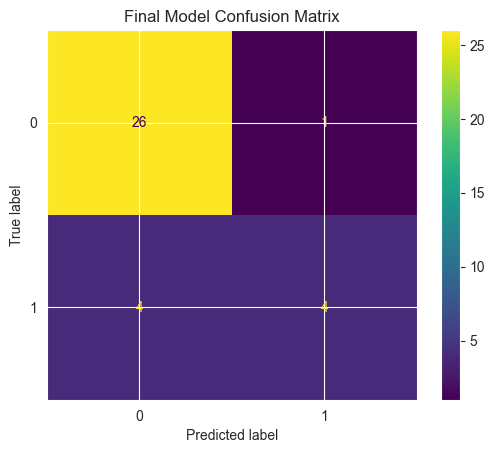

In [18]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title('Final Model Confusion Matrix')
plt.show()

# Feature Importance Plot

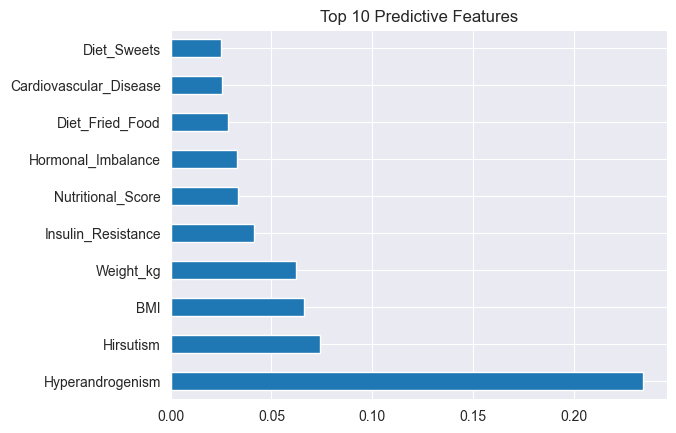

In [19]:
importances = best_rf.feature_importances_
pd.Series(importances, index=features.columns).nlargest(10).plot(kind='barh')
plt.title('Top 10 Predictive Features')
plt.show()